[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/W1D3_Tutorial6.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/W1D3_Tutorial6.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 6: Large Scale Climate Variability - ENSO

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google DeepMind

# Tutorial Objectives

In this tutorial, you will build upon the introduction to El Niño-Southern Oscillation (ENSO) from Day 1 and 2. ENSO is recognized as one of the most influential large-scale climate variabilities that impact weather and climate patterns.

By the end of this tutorial, you will:

- Enhance your comprehension of the concept of ENSO and the three distinct phases associated with it.
- Utilize satellite-derived sea surface temperature (SST) data to compute an index for monitoring ENSO.


# Setup

In [1]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# # properly install cartopy in colab to avoid session crash
# !apt-get install libproj-dev proj-data proj-bin --quiet
# !apt-get install libgeos-dev --quiet
# !pip install cython --quiet
# !pip install cartopy --quiet
# !pip install geoviews

# !apt-get -qq install python-cartopy python3-cartopy  --quiet
# !pip uninstall -y shapely  --quiet
# !pip install shapely --no-binary shapely  --quiet

# !pip install boto3 --quiet

# you may need to restart the runtime after running this cell and that is ok

In [2]:
# imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import os
import requests
import tarfile
import pooch
import os
import tempfile
import holoviews
from geoviews import Dataset as gvDataset
import geoviews.feature as gf
from geoviews import Image as gvImage

In [3]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

In [4]:
# @title Helper functions

def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/data/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

In [5]:
# @title Video 1: Satellite Data and Climate Variability

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'mP33aFGYQeA'), ('Bilibili', 'BV1ru411j71h')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [6]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "zkbaf"

# Section 1: El Niño-Southern Oscillation (ENSO)


As you learned in Day 1 and 2, one of the most significant large-scale climate variabilities is El Niño-Southern Oscillation (ENSO). ENSO can change the global atmospheric circulation, which in turn, influences temperature and precipitation across the globe.

Despite being a single climate phenomenon, ENSO exhibits three distinct phases:

- El Niño: A warming of the ocean surface, or above-average sea surface temperatures, in the central and eastern tropical Pacific Ocean.
- La Niña: A cooling of the ocean surface, or below-average sea surface temperatures, in the central and eastern tropical Pacific Ocean.
- Neutral: Neither El Niño or La Niña. Often tropical Pacific SSTs are generally close to average. 

In Day 2, you practiced utilizing a variety of Xarray tools to examine variations in sea surface temperature (SST) during El Niño and La Niña events by calculating the [Oceanic Niño Index (ONI)](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) from reanalysis data over the time period 2000-2014.

In contrast to previous days, in this tutorial you will use satellite-based SST data to monitor ENSO over a longer time period starting in 1981.

## Section 1.1: Calculate SST Anomaly

[Optimum Interpolation Sea Surface Temperature (OISST)](https://www.ncei.noaa.gov/products/optimum-interpolation-sst) is a long-term Climate Data Record that incorporates observations from different platforms (satellites, ships, buoys and Argo floats) into a regular global grid. OISST data is originally produced at daily and 1/4° spatial resolution. To avoid the large amount of data processing of daily data, we use the monthly aggregated OISST SST data provided by [NOAA Physical Systems Laboratory](https://psl.noaa.gov/). 

In [7]:
# download the monthly sea surface temperature data from NOAA Physical System
# Laboratory. The data is processed using the OISST SST Climate Data Records
# from the NOAA CDR program.
# the data downloading may take 2-3 minutes to complete.
# filename=sst.mon.mean.nc
url_sst = "https://osf.io/6pgc2/download/"
filename = "sst.mon.mean.nc"

# we divide the data into small chunks to allow for easier memory manangement. this is all done automatically, no need for you to do anything
ds = xr.open_dataset(
    pooch_load(filelocation=url_sst, filename=filename),
    chunks={"time": 25, "latitude": 200, "longitude": 200},
)
ds

<xarray.Dataset>
Dimensions:  (time: 499, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(25, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

The monthly OISST data is available starting from September of 1981. We will use the Niño 3.4 (5N-5S, 170W-120W) region to monitor the ENSO as identified in the map below provided by NOAA Climate portal.

![Location of four different nino regions ](https://www.climate.gov/sites/default/files/Fig3_ENSOindices_SST_large.png)

Credit: [NOAA](https://www.climate.gov/sites/default/files/Fig3_ENSOindices_SST_large.png)

The data is only available in full years starting 1982, so we will use 1982-2011 as the climatology period.

In [8]:
# get 30-year climatology from 1982-2011
sst_30yr = ds.sst.sel(time=slice("1982-01-01", "2011-12-01"))

# calculate monthly climatology
sst_clim = sst_30yr.groupby("time.month").mean()
sst_clim

<xarray.DataArray 'sst' (month: 12, lat: 720, lon: 1440)>
dask.array<transpose, shape=(12, 720, 1440), dtype=float32, chunksize=(12, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      Monthly Mean of Sea Surface Temperature
    units:          degC
    valid_range:    [-3. 45.]
    precision:      2.0
    dataset:        NOAA High-resolution Blended Analysis
    var_desc:       Sea Surface Temperature
    level_desc:     Surface
    statistic:      Monthly Mean
    parent_stat:    Individual Observations
    actual_range:   [-1.8  32.14]
    standard_name:  sea_surface_temperature

In [9]:
# calculate monthly anomaly
sst_anom = ds.sst.groupby("time.month") - sst_clim
sst_anom

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'sst' (time: 499, lat: 720, lon: 1440)>
dask.array<sub, shape=(499, 720, 1440), dtype=float32, chunksize=(25, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    month    (time) int64 9 10 11 12 1 2 3 4 5 6 7 ... 5 6 7 8 9 10 11 12 1 2 3

Now, we can take a look at the SST anomaly of a given month. We use January of 1998 to show the specific change of SST during that time period.

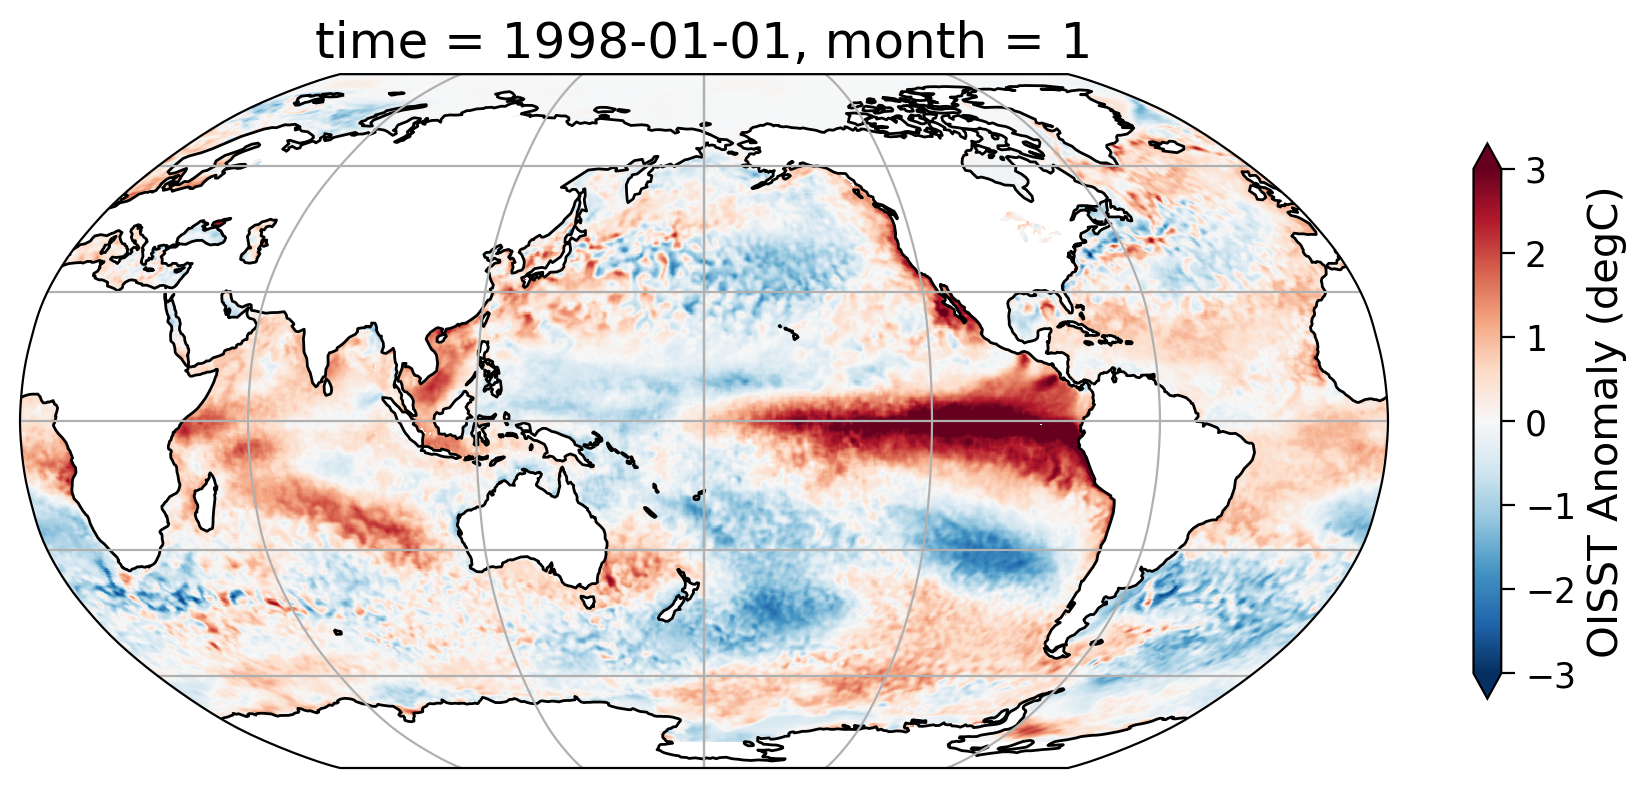

In [10]:
# properly install cartopy in colab to avoid session crash

sst = sst_anom.sel(time="1998-01-01")

# initate plot
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)}, figsize=(9, 6)
)

# focus on the ocean with the central_longitude=180
ax.coastlines()
ax.gridlines()
sst.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=-3,
    vmax=3,
    cmap="RdBu_r",
    cbar_kwargs=dict(shrink=0.5, label="OISST Anomaly (degC)"),
)

### **Interactive Demo 1.1**

Use the slider bar below to explore maps of the anomalies through the year in 1998.

In [11]:
# note this code takes a while to load. probably an hour
# holoviews.extension('bokeh')

# dataset_plot = gvDataset(sst_anom.sel(time=slice('1998-01-01','1998-12-01'))) # taking only 12 months
# images = dataset_plot.to(gvImage, ['lon', 'lat'], ['sst'], 'time')
# images.opts(cmap='RdBu_r', colorbar=True, width=600, height=400,projection=ccrs.Robinson(),
#             clim=(-3,3),clabel ='OISST Anomaly (degC)') * gf.coastline

## **Section 1.2: Monitoring ENSO with Oceanic Niño Index**

As you learned in Day 2, the [Oceanic Niño Index (ONI)](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) is a common index used to monitor ENSO. It is calculated using the Niño 3.4 region (5N-5S, 170W-120W) and by applying a 3-month rolling mean to the mean SST anomalies in that region.

You may have noticed that the `lon` for the SST data from [NOAA Physical Systems Laboratory](https://psl.noaa.gov/) is organized between 0°–360°E. Just as in Tutorial 1 of Day 2, we find that the region to subset with our dataset is (-5°–5°, 190–240°).

In [12]:
# extract SST data from the Nino 3.4 region
sst_nino34 = sst_anom.sel(lat=slice(-5, 5), lon=slice(190, 240))
sst_nino34

<xarray.DataArray 'sst' (time: 499, lat: 40, lon: 200)>
dask.array<getitem, shape=(499, 40, 200), dtype=float32, chunksize=(25, 40, 200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 -4.875 -4.625 -4.375 -4.125 ... 4.375 4.625 4.875
  * lon      (lon) float32 190.1 190.4 190.6 190.9 ... 239.1 239.4 239.6 239.9
    month    (time) int64 9 10 11 12 1 2 3 4 5 6 7 ... 5 6 7 8 9 10 11 12 1 2 3

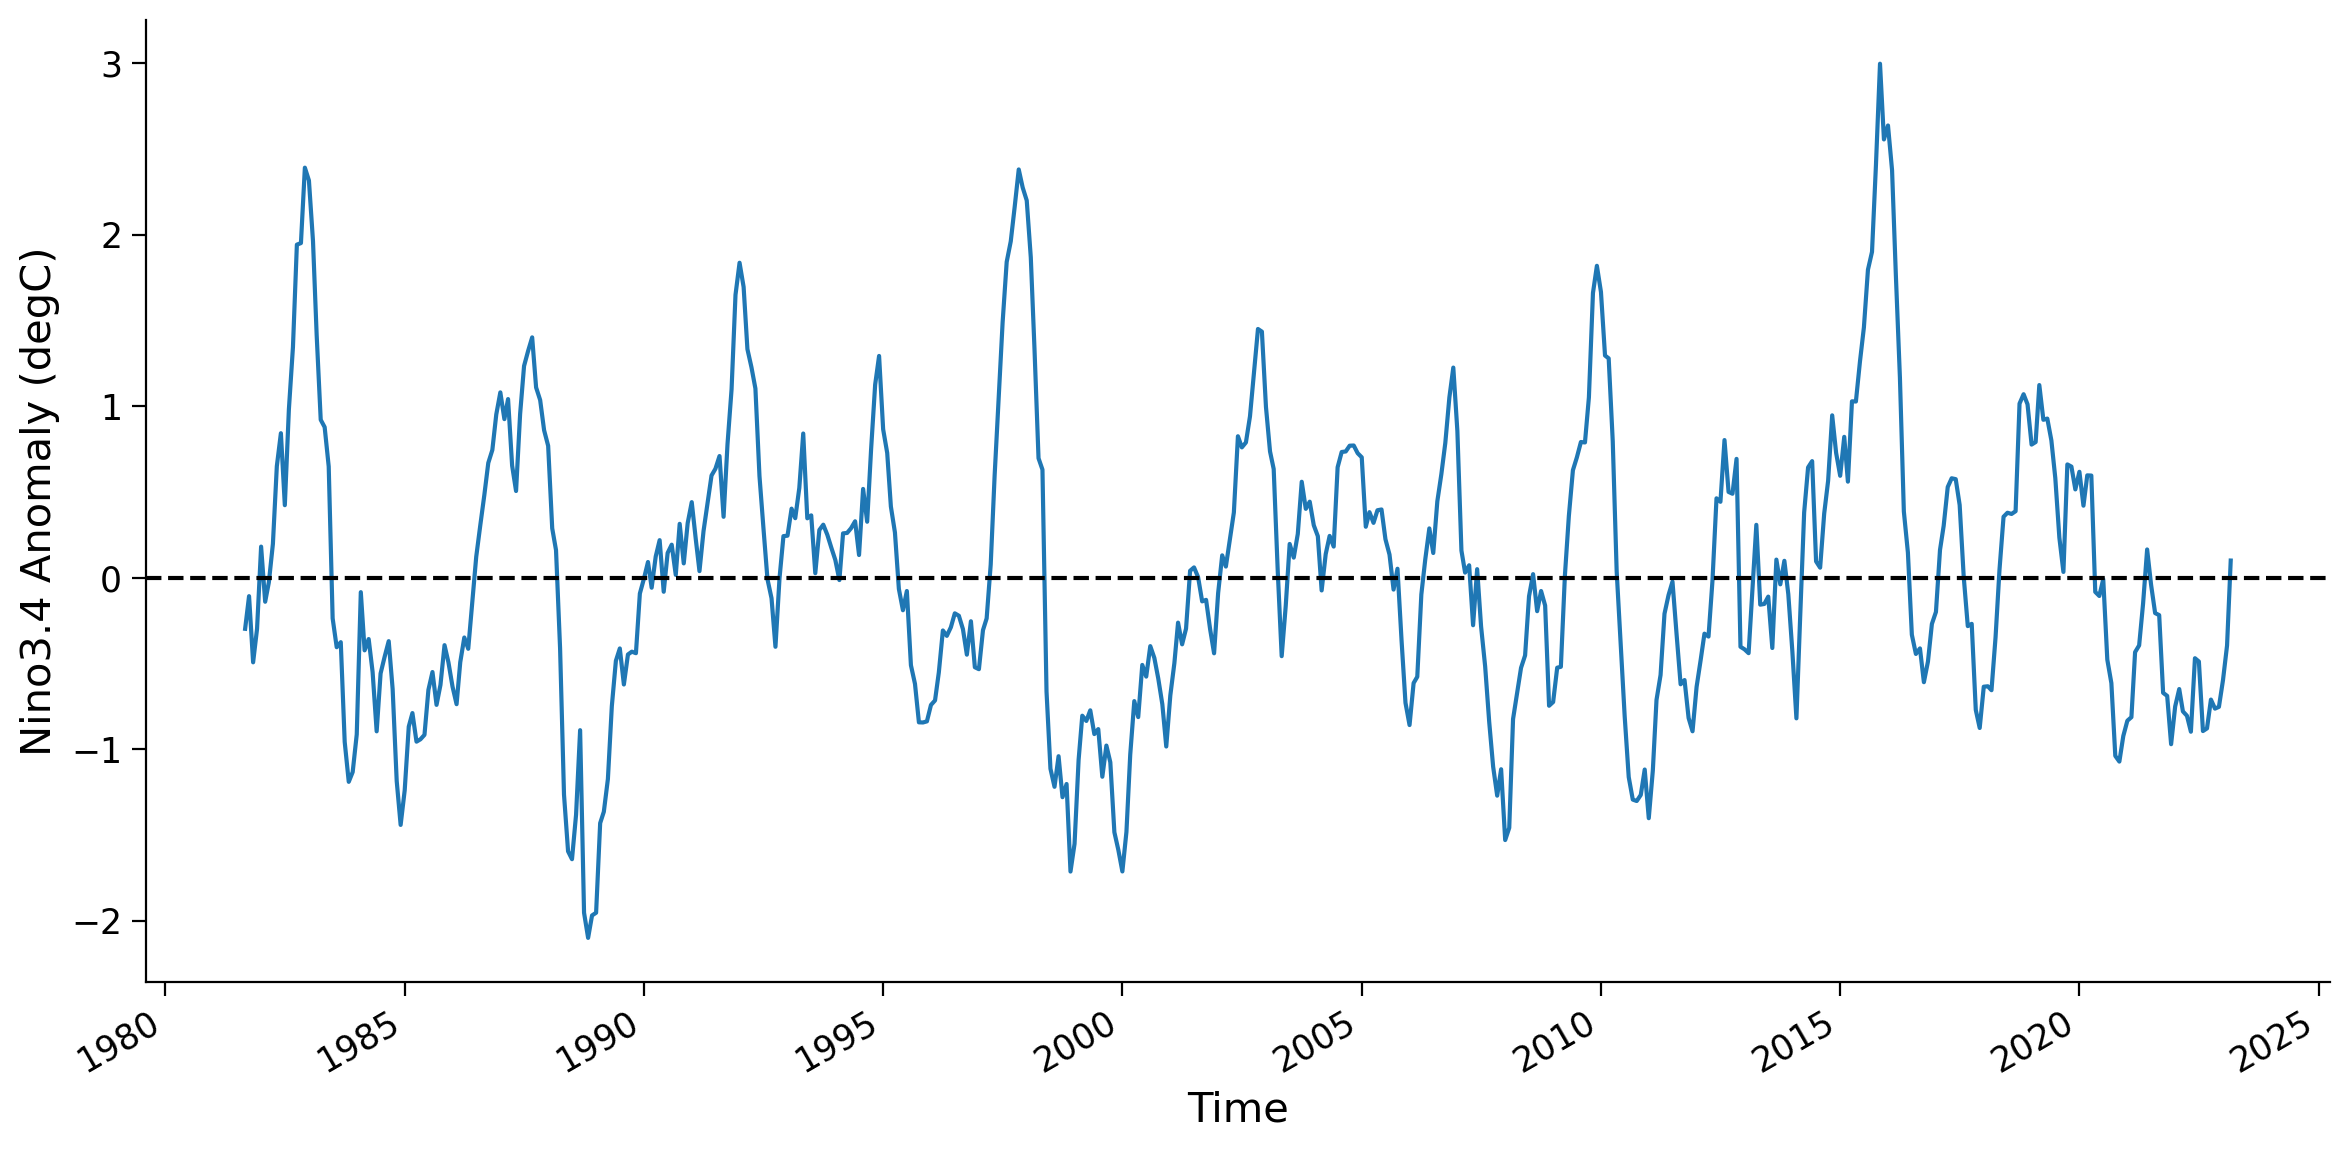

In [13]:
# calculate the mean values for the Nino 3.4 region
nino34 = sst_nino34.mean(dim=["lat", "lon"])

# Pplot time series for Nino 3.4 mean anomaly
fig, ax = plt.subplots(figsize=(12, 6))
nino34.plot(ax=ax)
ax.set_ylabel("Nino3.4 Anomaly (degC)")
ax.axhline(y=0, color="k", linestyle="dashed")

The ONI is defined as the 3-month rolling mean of the monthly regional average of the SST anomaly for the Nino 3.4 region. We can use `.rolling()` to calculate the ONI value for each month from the OISST monthly anomaly.

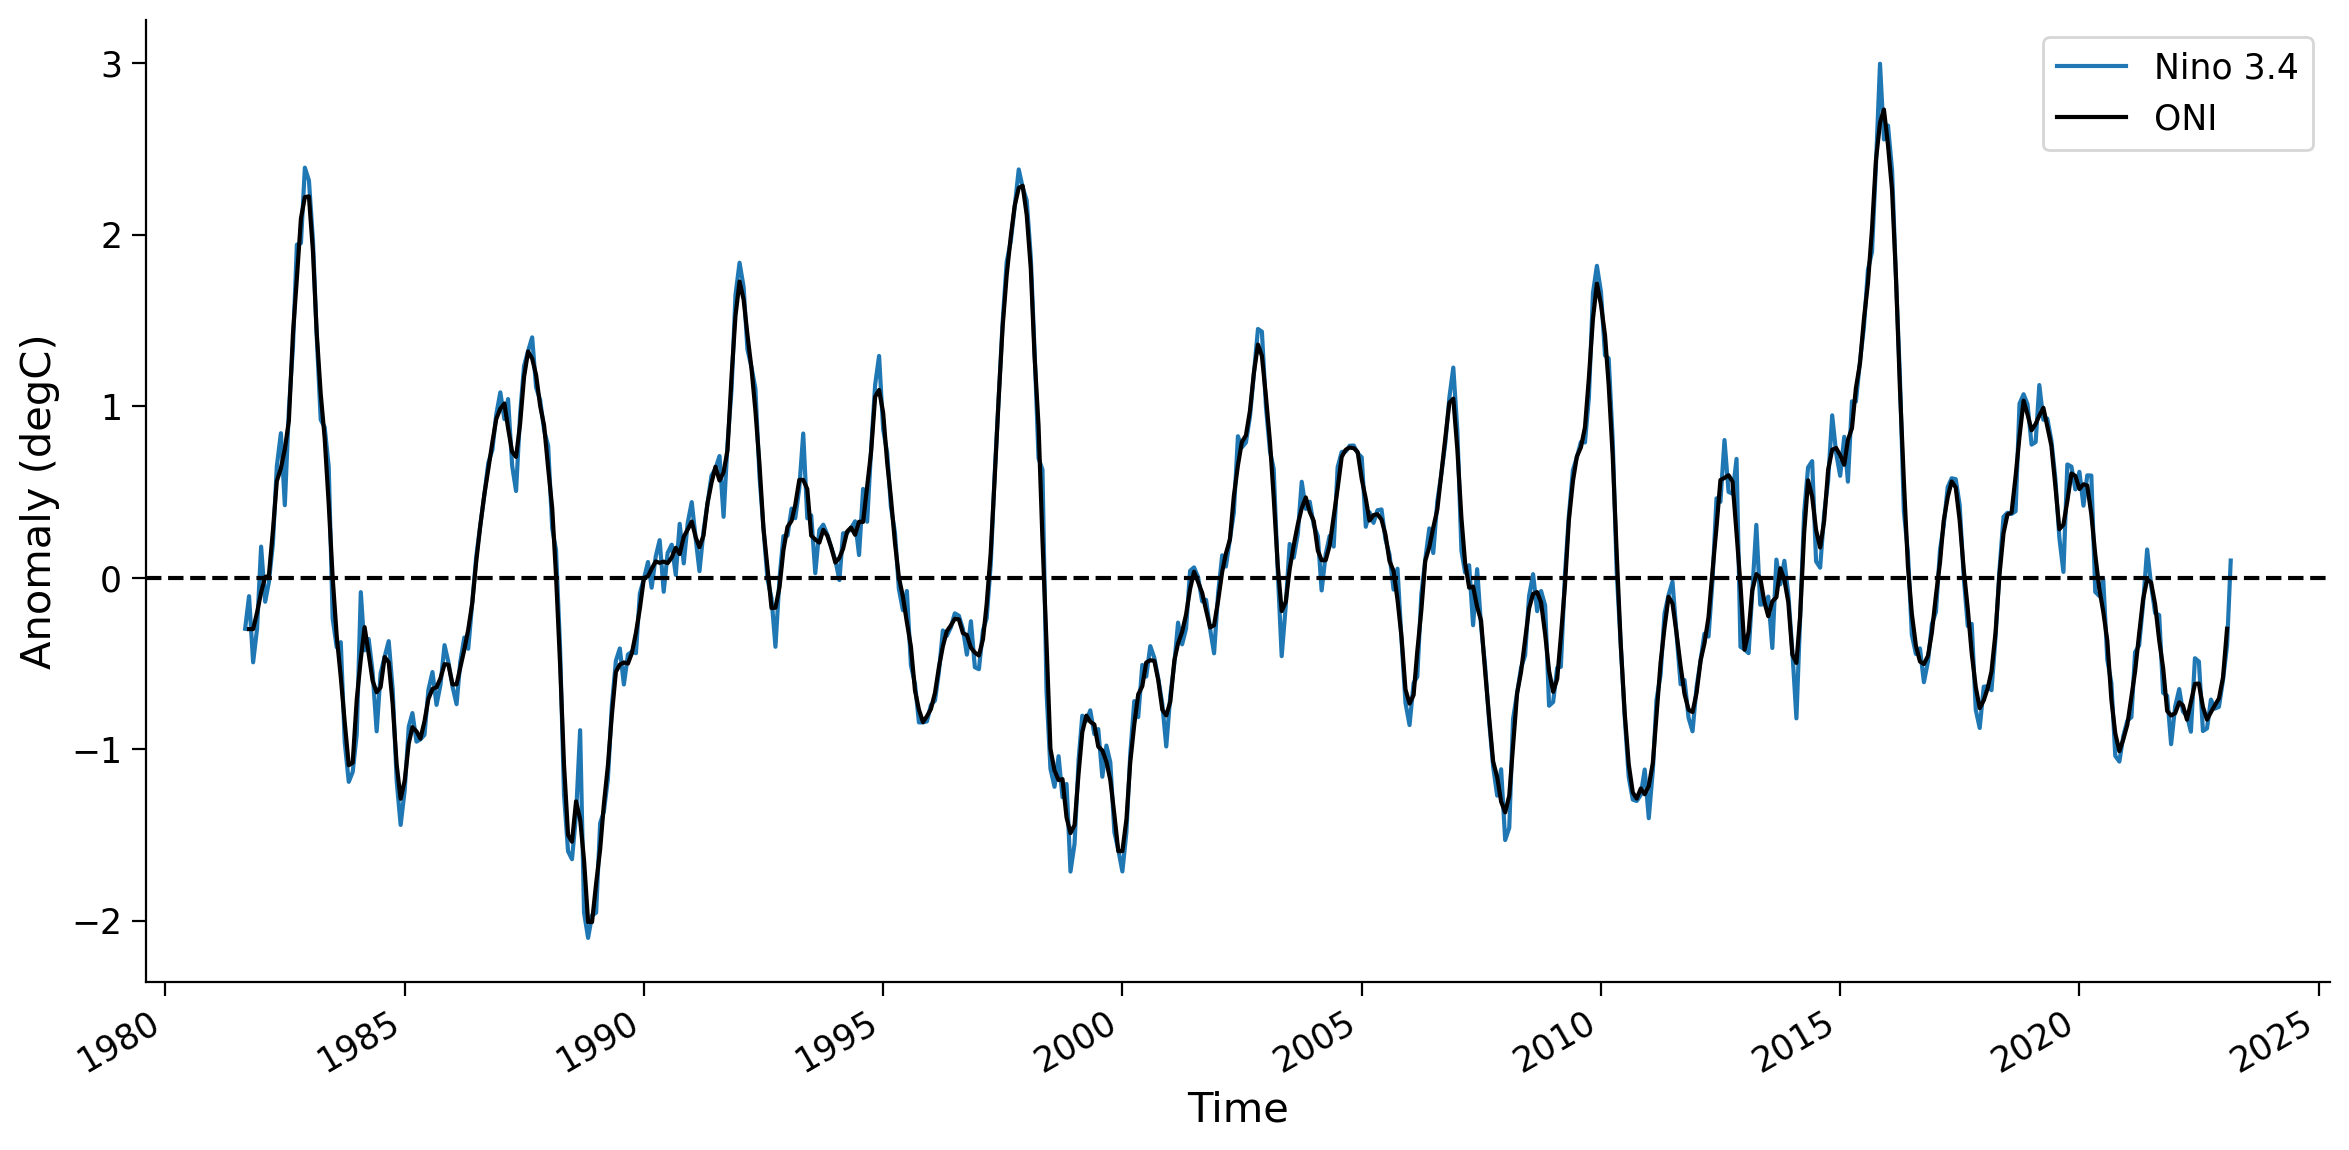

In [14]:
# calculate 3-month rolling mean of Nino 3.4 anomaly for the ONI
oni = nino34.rolling(time=3, center=True).mean()

# generate time series plot
fig, ax = plt.subplots(figsize=(12, 6))
nino34.plot(label="Nino 3.4", ax=ax)
oni.plot(color="k", label="ONI", ax=ax)
ax.set_ylabel("Anomaly (degC)")
ax.axhline(y=0, color="k", linestyle="dashed")
ax.legend()

The different phases of ENSO are nominally defined based on a threshold of $\pm$ 0.5 with the ONI index. 

- [El Niño](https://glossary.ametsoc.org/wiki/El_niño) [ONI values higher than 0.5]: surface waters in the east-central tropical Pacific are at least 0.5 degrees Celsius *warmer than normal*.
- [La Niña](https://glossary.ametsoc.org/wiki/La_niña) [ONI values lower than -0.5]: surface waters ub the west tropical Pacific are at least 0.5 degrees Celsius *cooler than normal*.

The neutral phase is when ONI values are in between these two thresholds. We can make the ONI plot that is used by NOAA and other organizations to monitor ENSO phases.

Text(0.5, 1.0, 'Oceanic Niño Index')

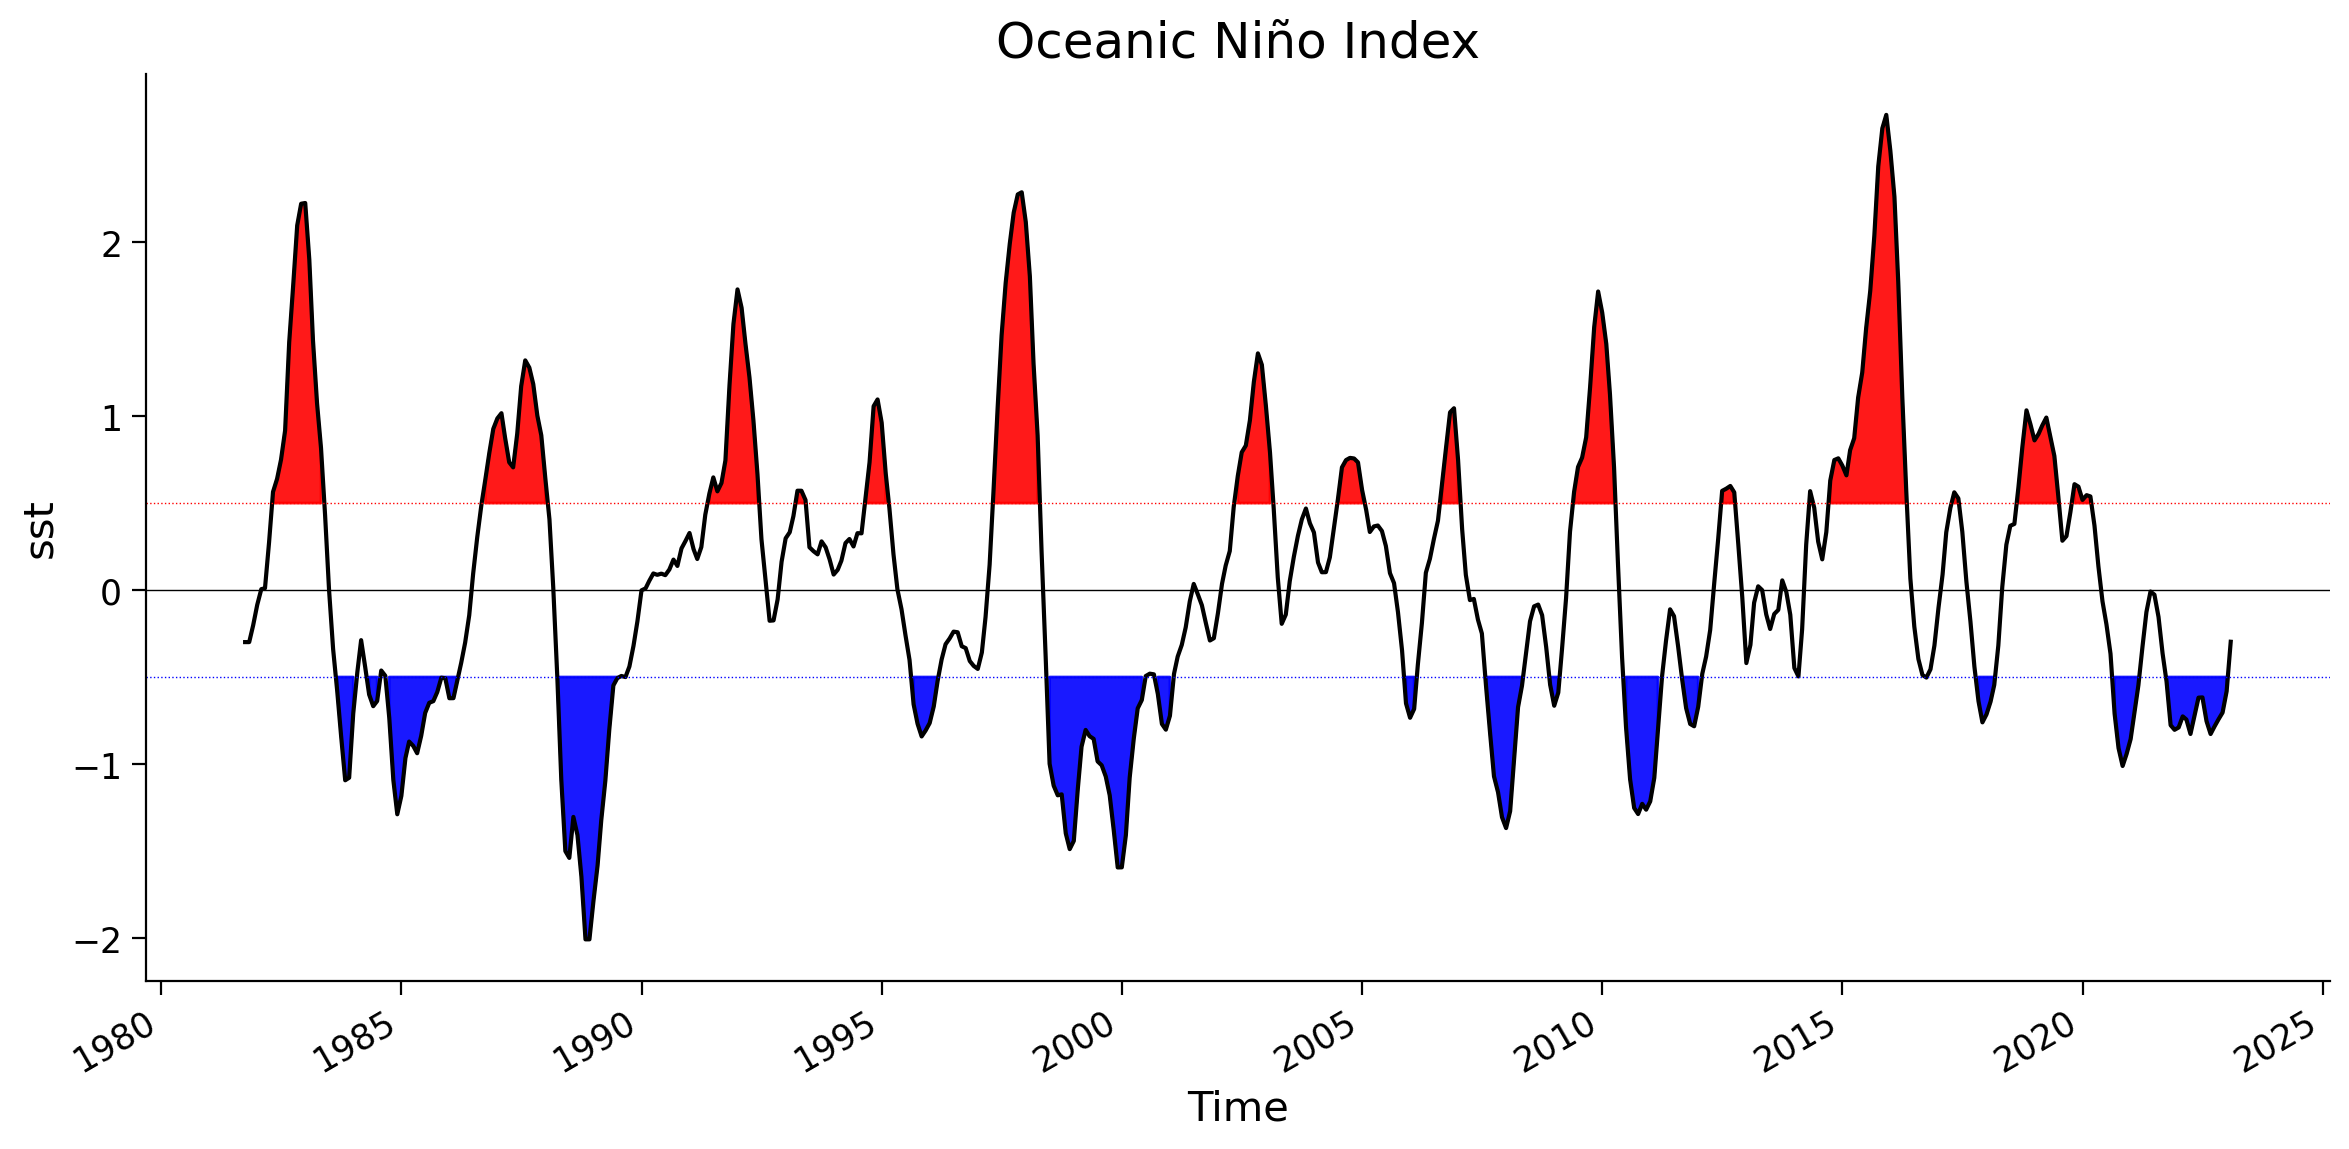

In [15]:
# set up the plot size
fig, ax = plt.subplots(figsize=(12, 6))

# create the filled area when ONI values are above 0.5 for El Nino
ax.fill_between(
    oni.time.data,
    oni.where(oni >= 0.5).data,
    0.5,
    color="red",
    alpha=0.9,
)

# create the filled area when ONI values are below -0.5 for La Nina
ax.fill_between(
    oni.time.data,
    oni.where(oni <= -0.5).data,
    -0.5,
    color="blue",
    alpha=0.9,
)

# create the time series of ONI
oni.plot(color="black", ax=ax)

# add the threshold lines on the plot
ax.axhline(0, color="black", lw=0.5)
ax.axhline(0.5, color="red", linewidth=0.5, linestyle="dotted")
ax.axhline(-0.5, color="blue", linewidth=0.5, linestyle="dotted")
ax.set_title("Oceanic Niño Index")

From the plot, we can see the historical ENSO phases swing from El Nino to La Nina events. The major ENSO events like 1997-1998 shows up very clearly on the ONI plot. 

We will use the ONI data to perform analysis to understand the impact of ENSO on precipitation. So you can export the ONI time series into a netCDF file for future use via `.to_netcdf()`. For our purposes, we will download a dataset that has been previously saved in the next tutorial. If you wanted to save the data when working on your own computer, this is the code you could use.

In [16]:
# oni.to_netcdf('t6_oceanic-nino-index.nc')

### Coding Exercises 1.2

As we learned here, ENSO is monitored using the anomaly of SST data for a specific region (e.g., Nino 3.4). We also learned previously that the reference periods used to calculate climatolgies are updated regularly to reflect the most up to date 'normal'.

1. Compare the ONI time series calculated using two different climatology reference periods (1982-2011 v.s. 1991-2020). 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


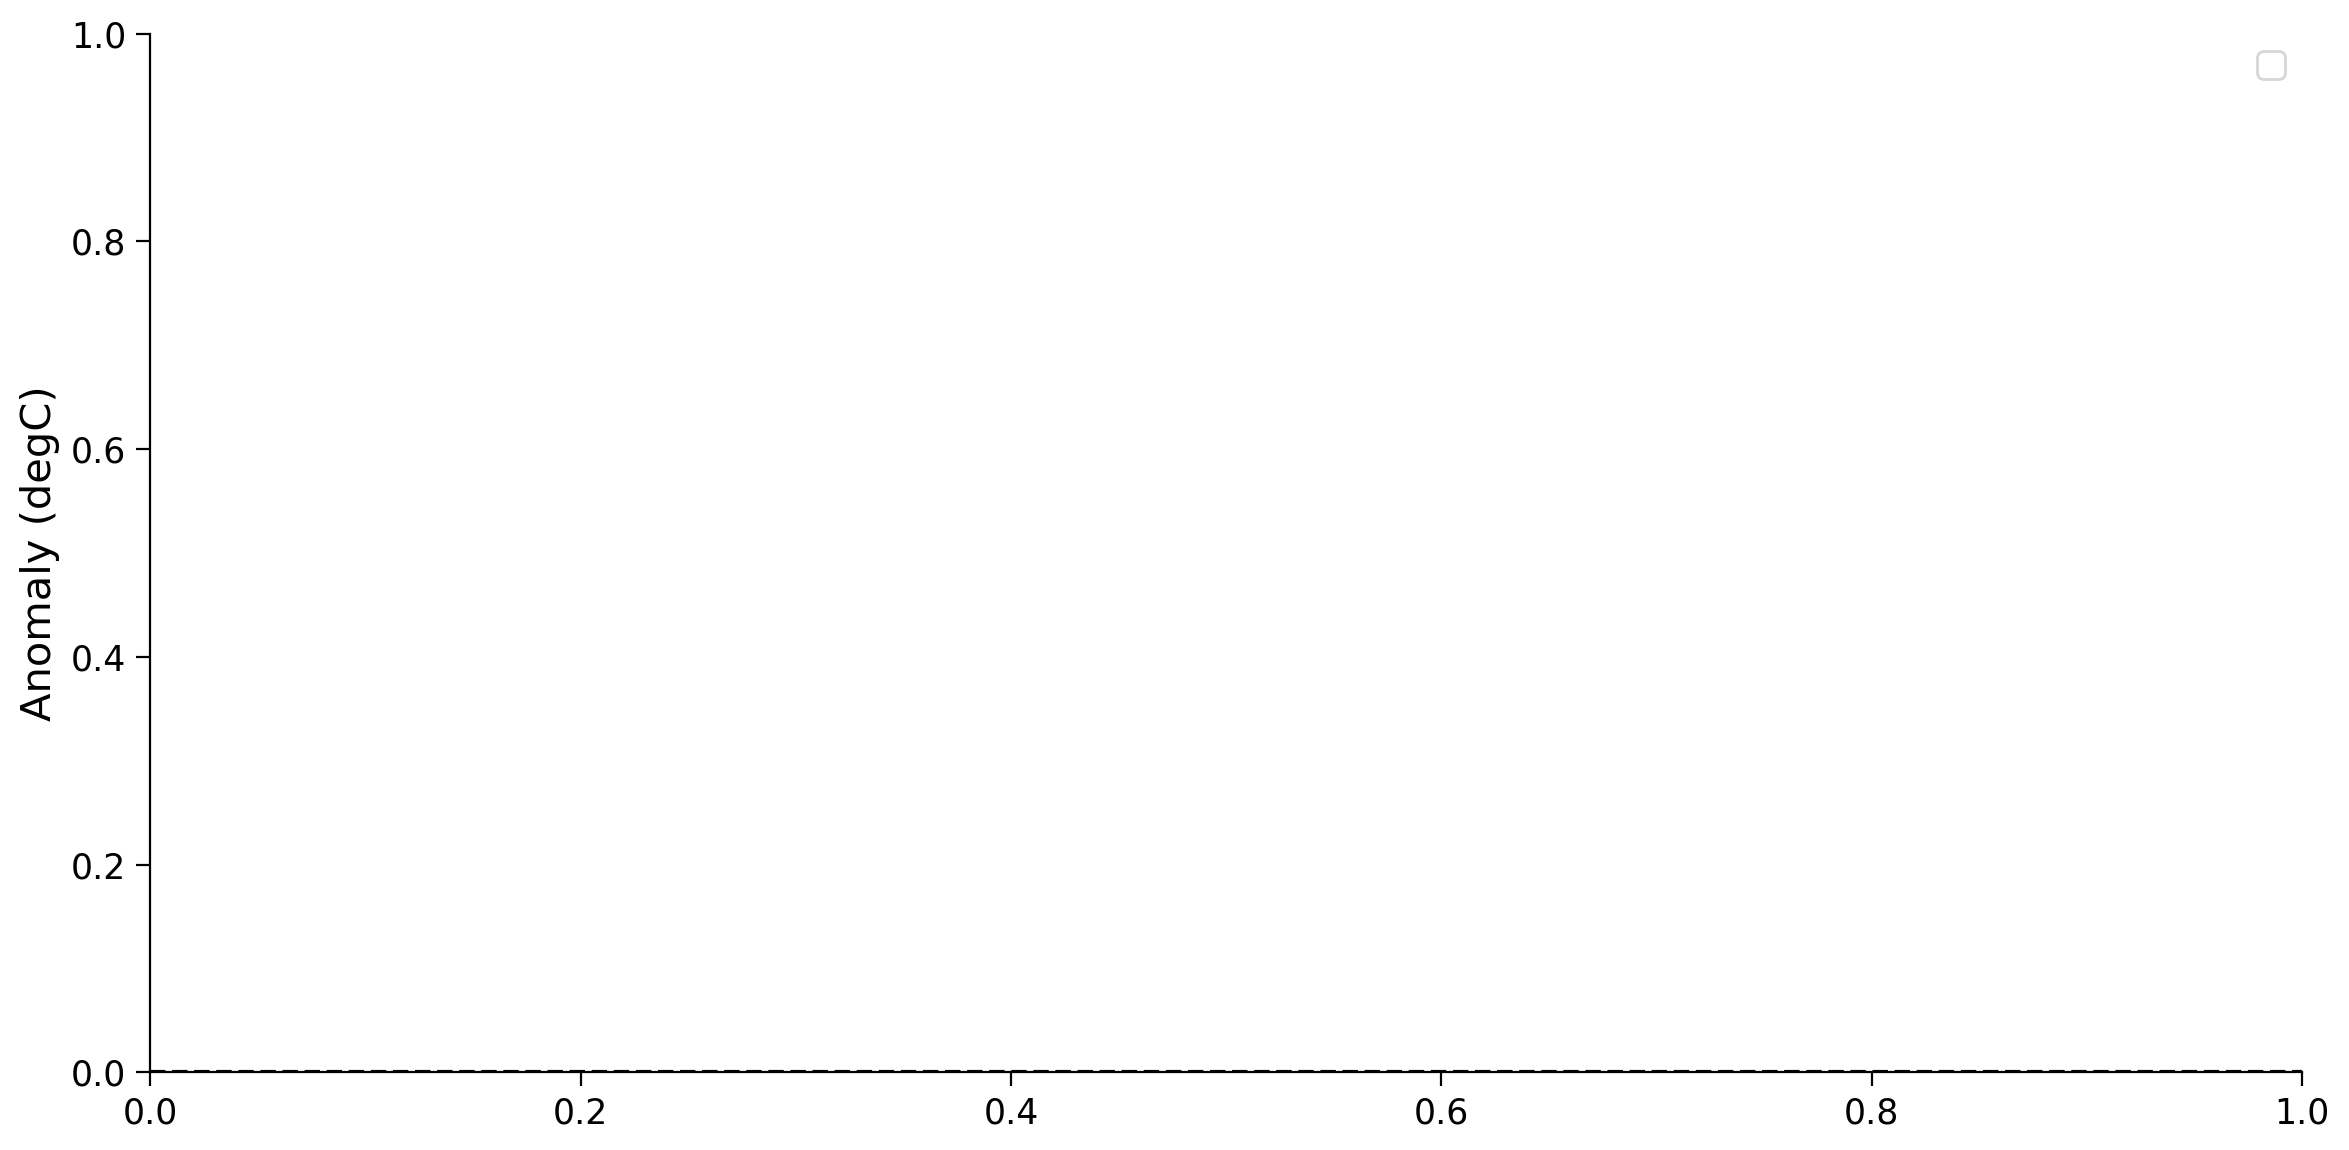

In [17]:
# select data from 1991-2020.
sst_30yr_later = ...

# calculate climatology
sst_clim_later = ...

# calculate anomaly
sst_anom_later = ...

# calculate mean over Nino 3.4 region
nino34_later = ...

# compute 3 month rolling mean
oni_later = ...

# compare the two ONI time series and visualize the difference as a time series plot
fig, ax = plt.subplots(figsize=(12, 6))
# oni.plot(color="k", label="ONI (1982-2011)", ax=ax)
# oni_later.plot(color="r", label="ONI (1991-2020)", ax=ax)
ax.set_ylabel("Anomaly (degC)")
ax.axhline(y=0, color="k", linestyle="dashed")
ax.legend()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


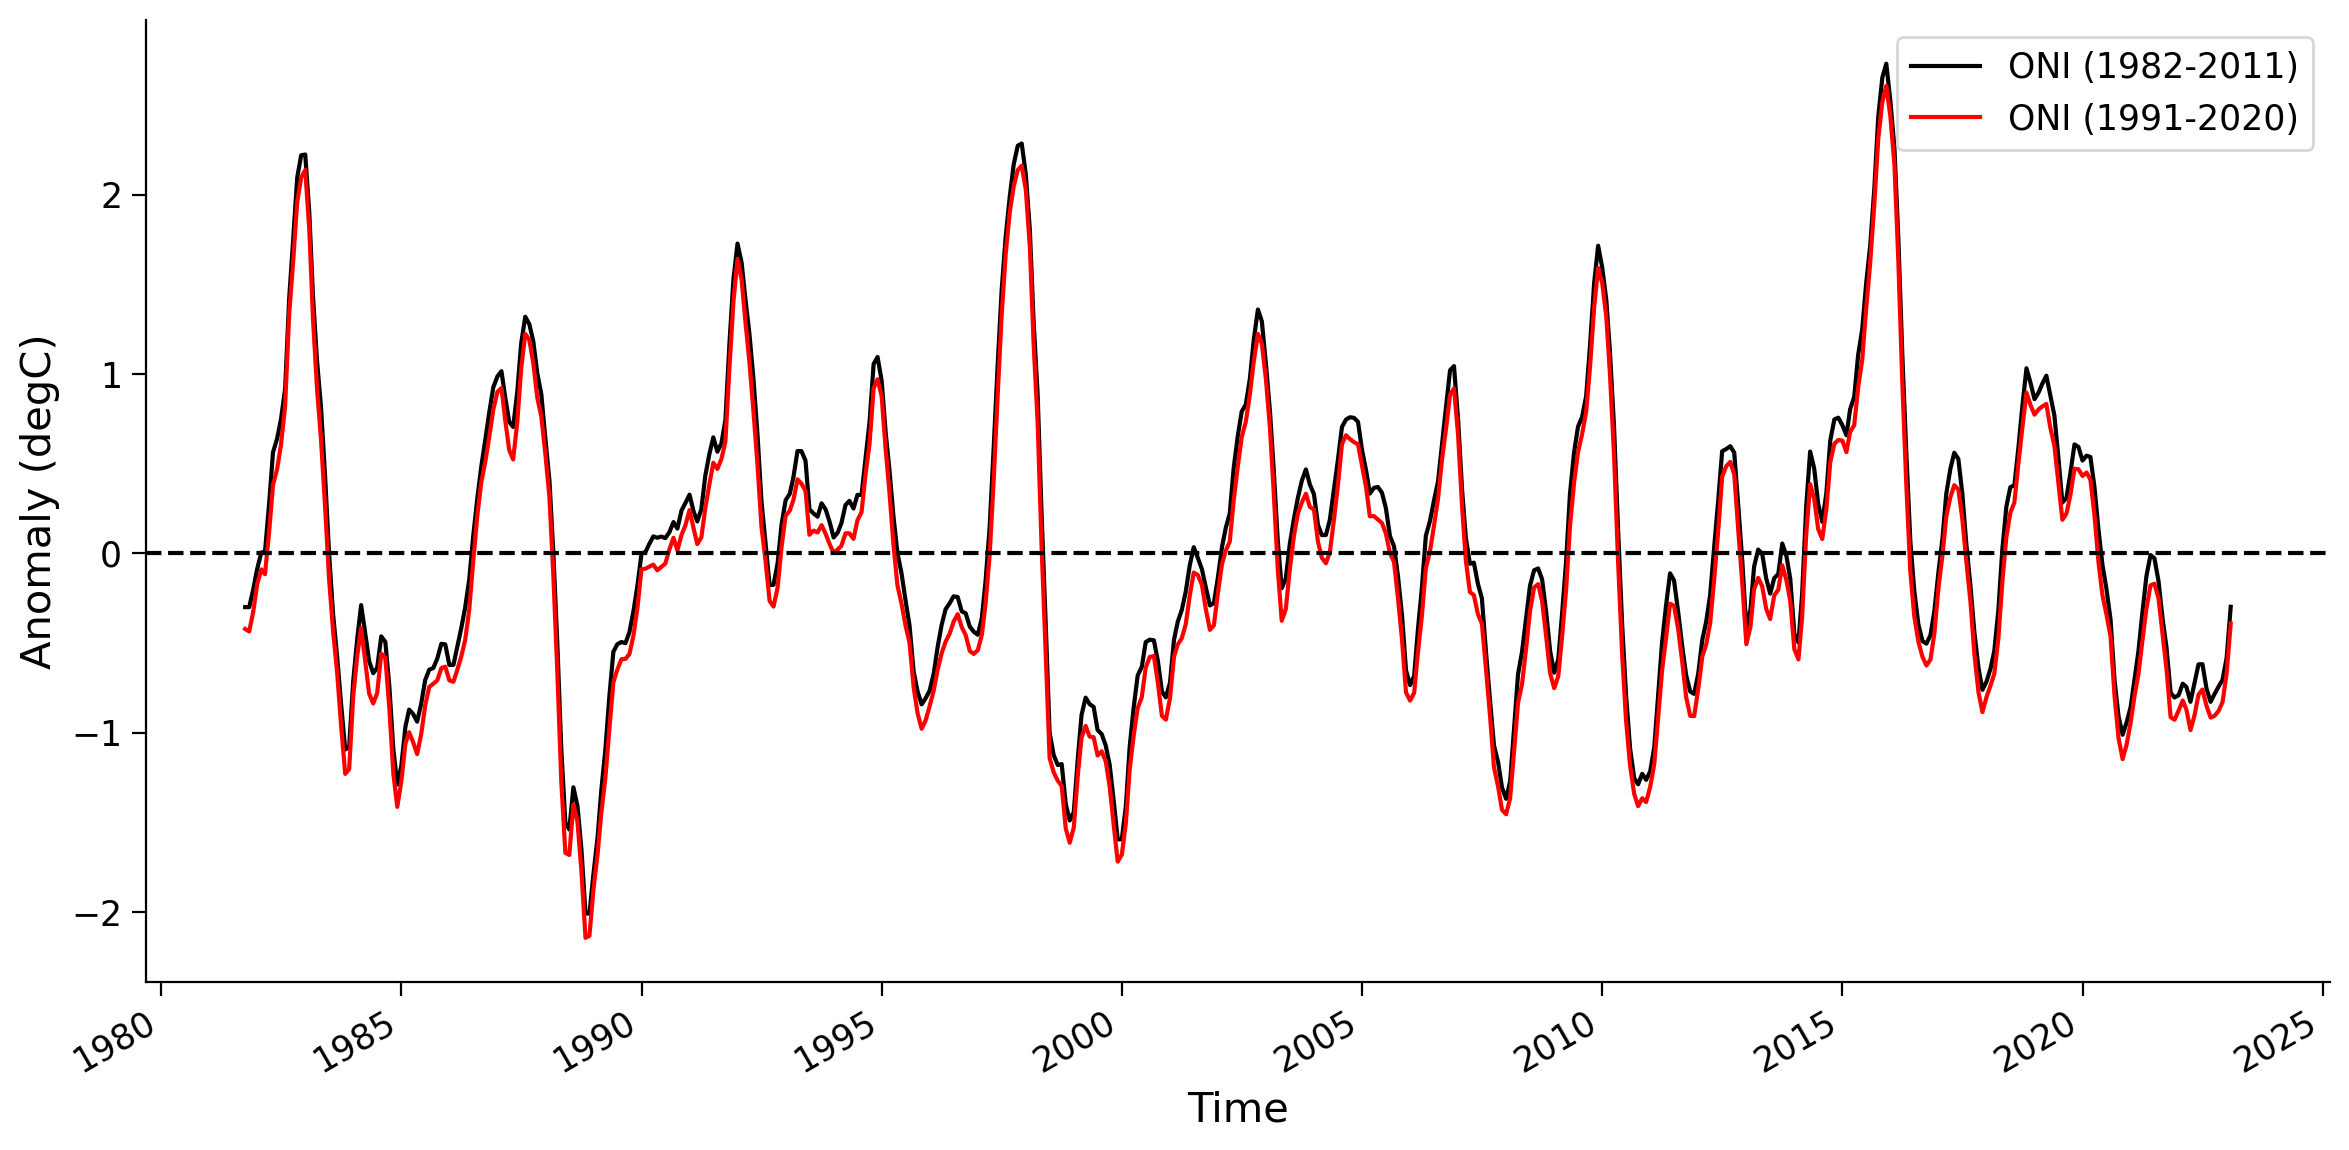

In [18]:
# to_remove solution

# select data from 1991-2020.
sst_30yr_later = ds.sst.sel(time=slice("1991-01-01", "2020-12-30"))

# calculate climatology
sst_clim_later = sst_30yr_later.groupby("time.month").mean()

# calculate anomaly
sst_anom_later = ds.sst.groupby("time.month") - sst_clim_later

# calculate mean over Nino 3.4 region
nino34_later = sst_anom_later.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(
    dim=["lat", "lon"]
)

# compute 3 month rolling mean
oni_later = nino34_later.rolling(time=3, center=True).mean()

# compare the two ONI time series and visualize the difference as a time series plot
fig, ax = plt.subplots(figsize=(12, 6))
oni.plot(color="k", label="ONI (1982-2011)", ax=ax)
oni_later.plot(color="r", label="ONI (1991-2020)", ax=ax)
ax.set_ylabel("Anomaly (degC)")
ax.axhline(y=0, color="k", linestyle="dashed")
ax.legend()

### Questions 1.2: Climate Connection

1. What is the main difference you note about this plot?
2. What does this tell you about the climatology calculated from 1982-2011 versus 1991-2020?
3. Why is it important to use appropriate climatologies when finding anomalies?

In [19]:
# to_remove explanation

'''
1. The index using the 1982-2011 reference period is always a little larger than the 1991-2020 reference period curve.
2. This means that the climatology values for the 1991-2020 reference period were larger than that of 1982-2011.
3. This can help remove long term trends (e.g. from warming) that can obscure the anomalies and ensures the anomaly is to the correct 'normal'.
''';

# Summary

In this tutorial, you revisted the foundational principles of ENSO and explored how satellite data can be employed to track this phenomenon. 
- As one of the most potent climate influences on Earth, ENSO has the capacity to alter global atmospheric circulation with impacts around the world.
- You observed the three phases of ENSO by utilizing SST data gathered from satellites and calculating the Oceanic Niño Index.

In the forthcoming tutorial, we will utilize the ONI, calculated in this session, to evaluate the influence of ENSO on precipitation in select regions. 


# Resources

Data from this tutorial can be accessed [here](https://www.ncei.noaa.gov/products/optimum-interpolation-sst).